## **Tehnička priprema**


---





In [ ]:
# biblioteke za snimanje video zapisa
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.*

!pip install gym==0.23.1
!pip install box2d-py
!pip install pygame
!pip install stable_baselines3
!pip install gym==0.23.1

In [ ]:
# ovim se povezujemo sa Google Drive-om i podacima u njemu
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importovanje potrebnih biblioteka i priprema metode za prikaz snimljenog videa.
import gym
from base64 import b64encode
import numpy as np
from IPython.display import HTML
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from pyvirtualdisplay import Display

# importovanje ostalih biblioteka koje koristimo
import keras
from keras import models
from keras import layers

def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'


display = Display(visible=False, size=(1400, 900))
_ = display.start()

import numpy as np
np.set_printoptions(precision=3)

import matplotlib.pyplot as plt

from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

projekat_folder = "drive/My Drive/UMU/projekat/"
video_putanja = projekat_folder+"video.mp4"


## **Okruženje - LunarLander-v2**

In [ ]:
import gym

# učitavamo LunarLander okruženje
ime_okruzenja = "LunarLander-v2" 
okruzenje = gym.make(ime_okruzenja) 
spec = gym.spec(ime_okruzenja) # specifikacije okruženja
seed = 42 # fiksiranje nasumicnosti da bi se okruzenje isto ponasalo kad ponovimo program 
okruzenje.reset(seed=seed)

print(f"Akcije okruženja: { okruzenje.action_space }")
print(f"Dimenzije stanja: { okruzenje.observation_space }")
print(f"Maksimalan broj koraka: { spec.max_episode_steps }")
print(f"Opseg vrednosti nagrade: { okruzenje.reward_range }")
print(f"Prag nagrade: { spec.reward_threshold }") 

Akcije okruženja: Discrete(4)
Dimenzije stanja: Box(-inf, inf, (8,), float32)
Maksimalan broj koraka: 1000
Opseg vrednosti nagrade: (-inf, inf)
Prag nagrade: 200


# **Random**

Ovde ćemo videti koliko bi uspešno (neuspešno) agent rešio problem nasumičnim odabirom akcije - bez ikakvih algoritama za učenje.

In [ ]:
video = VideoRecorder(okruzenje, video_putanja)

korak=0
ukupna_nagrada = 0
gotovo=False

stanje = okruzenje.reset()
while not gotovo:
  akcija = okruzenje.action_space.sample() # za početak, u svakom koraku izabiremo akciju random, iz skupa mogućih akcija u okruženju.
  stanje, nagrada, gotovo, info = okruzenje.step(akcija) # prosleđujemo odabranu akciju, okruženje vraća novo stanje, novu nagradu, informaciju da li je epizoda završila
  ukupna_nagrada += nagrada
  korak+=1

  print(f"Korak: {korak},\t izabrana akcija: {akcija},\t novo stanje: {stanje},\t nagrada: {nagrada},\t gotova epizoda {gotovo},\t  info {info}")

  video.capture_frame()
video.close()
print(f"Ukupna nagrada: { ukupna_nagrada }")

/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:116: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  '`env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` '


Korak: 1,	 izabrana akcija: 1,	 novo stanje: [-0.011  1.418 -0.569  0.144  0.015  0.167  0.     0.   ],	 nagrada: -1.4359782430063308,	 gotova epizoda False,	  info {}
Korak: 2,	 izabrana akcija: 1,	 novo stanje: [-0.017  1.421 -0.58   0.117  0.025  0.213  0.     0.   ],	 nagrada: -1.8823423231084166,	 gotova epizoda False,	  info {}
Korak: 3,	 izabrana akcija: 1,	 novo stanje: [-0.023  1.423 -0.59   0.09   0.038  0.253  0.     0.   ],	 nagrada: -2.0141607173847818,	 gotova epizoda False,	  info {}
Korak: 4,	 izabrana akcija: 3,	 novo stanje: [-0.028  1.424 -0.58   0.064  0.049  0.21   0.     0.   ],	 nagrada: 0.17296801811173282,	 gotova epizoda False,	  info {}
Korak: 5,	 izabrana akcija: 3,	 novo stanje: [-0.034  1.425 -0.568  0.037  0.057  0.164  0.     0.   ],	 nagrada: 0.4280677648117728,	 gotova epizoda False,	  info {}
Korak: 6,	 izabrana akcija: 0,	 novo stanje: [-0.039  1.425 -0.568  0.01   0.065  0.164  0.     0.   ],	 nagrada: -0.7476779765088963,	 gotova epizoda False,	  i

In [ ]:
HTML(render_mp4(video_putanja))

# **A2C**

Ovaj algoritam radi i sa kontinualnim i sa diskretnim vrednostima. Optimizuje polisu i nadgradnja je *Reinforce-a*, jer u isto vreme uči i vrednosnu funkciju stanja V(s).

In [ ]:
from stable_baselines3 import A2C
import torch

In [ ]:
ime_okruzenja = "LunarLander-v2" 
okruzenje = gym.make(ime_okruzenja) 
spec = gym.spec(ime_okruzenja) 
okruzenje.seed(42)


/usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


[42]

**Početna analiza na defaultnim parametrima algoritma**

Pozivanjem funkcije *model.learn* više puta i praćenjem najboljeg modela kroz trening, možemo zaključiti optimalan broj koraka. Funkciju uvek pozivamo za 500k koraka (bolje što više koraka, za svaki slučaj).

In [ ]:
paralelno_okruzenje=make_vec_env("LunarLander-v2",n_envs=4,seed=42)

najbolji_model_eksperiment1_putanja = projekat_folder + "best_modelA2C_500k_n_envs=4"
logovi_evaluacije_eksperiment1_putanja = projekat_folder + "log_best_modelA2C_500k_n_envs=4"

eval_callback = EvalCallback(okruzenje, best_model_save_path=najbolji_model_eksperiment1_putanja,
                             log_path=logovi_evaluacije_eksperiment1_putanja, eval_freq=1000,
                             deterministic=True, render=False)

# eval_callback nam govori kada dodjemo do boljeg modela; štaviše, pamti ga

model = A2C('MlpPolicy',paralelno_okruzenje,verbose=1)

model.learn(500000, callback=eval_callback,log_interval=5000)

Grafičko predstavljanje (opcionalno)

Ćeliju koda iznad treba pokrenuti, kao što je već rečeno, više puta. Naime, neke parametre jednostavno ne bi valjalo analizirati pomoću samo jednog modela - može se doći do pogrešnih zaključaka.

Nažalost, mi smo sačuvali samo dva modela, ali to će biti dovoljno za opis analize (trening je pokretan 8 puta i ti rezultati odgovaraju zaključku za optimalan broj koraka koji smo izveli nekoliko ćelija ispod).

In [ ]:
putanja_logova=projekat_folder+"log_best_modelA2C_500k_n_envs=4/evaluations.npz"
logovi1=np.load(putanja_logova)
print(f"Dostupni podfajlovi: \n{logovi1.files}")

Dostupni podfajlovi: 
['timesteps', 'results', 'ep_lengths']


In [ ]:
putanja_logova=projekat_folder+"log_best_modelA2C_500k/evaluations.npz"
logovi2=np.load(putanja_logova)
print(f"Dostupni podfajlovi: \n{logovi2.files}")

Dostupni podfajlovi: 
['timesteps', 'results', 'ep_lengths']


Text(0, 0.5, 'nagrada')

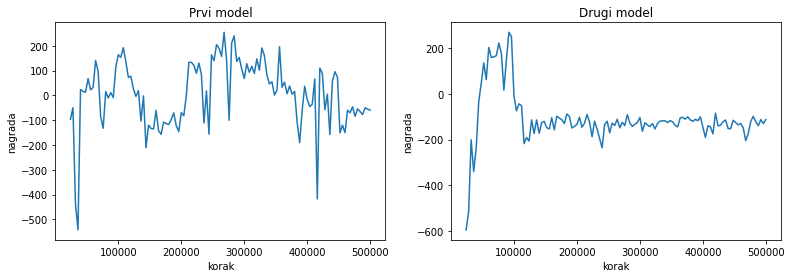

In [ ]:
x1 = logovi1['timesteps'][5:] 
y1 = np.mean(logovi1['results'][5:], axis=1)

x2 = logovi2['timesteps'][5:] 
y2 = np.mean(logovi2['results'][5:], axis=1)

# ne crtamo prvih 5 tačaka, jer su vrednosti na y - osi ogromne
# i ne vide se lepo nagrade na većem rednom broju koraka

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[13,4])

ax1.plot(x1, y1)
ax2.plot(x2, y2)

ax1.set_title('Prvi model')
ax1.set_xlabel('korak')
ax1.set_ylabel('nagrada')

ax2.set_title('Drugi model')
ax2.set_xlabel('korak')
ax2.set_ylabel('nagrada')

Više od 400k koraka je nepotrebno (nema boljeg modela modela posle 400k). Štaviše, 300k koraka je dovoljno.

Uočite i špiceve kod grafika. Eveal_callback nam je zato neizostavan.

Grafici su različiti. Ako hoćemo da model bude uvek isti kada opet pokrenemo ćeliju treninga, moramo staviti neki ceo broj za seed okruženja i seed kao parametar u deklarisanju A2C-a.

**Polisa**

In [ ]:
#prvo probamo sa defaultnom polisom [64,64]

paralelno_okruzenje=make_vec_env("LunarLander-v2",n_envs=4,seed=42) #treniramo u četvorostrukom okruženju, zbog brzine

najbolji_model_eksperiment1_putanja = projekat_folder + "proba"
logovi_evaluacije_eksperiment1_putanja = projekat_folder + "log_proba"

eval_callback = EvalCallback(okruzenje, best_model_save_path=najbolji_model_eksperiment1_putanja,
                             log_path=logovi_evaluacije_eksperiment1_putanja, eval_freq=1000,
                             deterministic=True, render=False)

model = A2C('MlpPolicy',paralelno_okruzenje,seed=42,verbose=1)
model.learn(100000, callback=eval_callback,log_interval=5000)

In [ ]:
#probamo sa manjom polisom [40,32]

policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=[dict(pi=[40, 32], vf=[40, 32])])
paralelno_okruzenje=make_vec_env("LunarLander-v2",n_envs=4,seed=42)

najbolji_model_eksperiment1_putanja = projekat_folder + "proba_sa_policy_kwargs"
logovi_evaluacije_eksperiment1_putanja = projekat_folder + "log_proba_sa_policy_kwargs"

eval_callback = EvalCallback(okruzenje, best_model_save_path=najbolji_model_eksperiment1_putanja,
                             log_path=logovi_evaluacije_eksperiment1_putanja, eval_freq=1000,
                             deterministic=True, render=False)



model = A2C('MlpPolicy',paralelno_okruzenje,policy_kwargs=policy_kwargs,seed=42,verbose=1)

model.learn(100000, callback=eval_callback,log_interval=5000)

In [ ]:
#probamo sa malo većom polisom, ali manjom od defaultne (pošto onaj rezultat nije obećavajuć)

policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=[dict(pi=[50, 48], vf=[50, 48])])
paralelno_okruzenje=make_vec_env("LunarLander-v2",n_envs=4,seed=42)

najbolji_model_eksperiment1_putanja = projekat_folder + "best_modelA2C[52,48]"
logovi_evaluacije_eksperiment1_putanja = projekat_folder + "log_best_modelA2C[52,48]"

eval_callback = EvalCallback(okruzenje, best_model_save_path=najbolji_model_eksperiment1_putanja,
                             log_path=logovi_evaluacije_eksperiment1_putanja, eval_freq=1000,
                             deterministic=True, render=False)



model = A2C('MlpPolicy',paralelno_okruzenje,policy_kwargs=policy_kwargs,seed=42,verbose=1)

model.learn(100000, callback=eval_callback,log_interval=5000)

In [ ]:
#probamo sa većom polisom [82,82]

policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=[dict(pi=[82, 82], vf=[82, 82])])
paralelno_okruzenje=make_vec_env("LunarLander-v2",n_envs=4,seed=42)

najbolji_model_eksperiment1_putanja = projekat_folder + "best_modelA2C[82,82]'"
logovi_evaluacije_eksperiment1_putanja = projekat_folder + "log_best_modelA2C[82,82]'"

eval_callback = EvalCallback(okruzenje, best_model_save_path=najbolji_model_eksperiment1_putanja,
                             log_path=logovi_evaluacije_eksperiment1_putanja, eval_freq=1000,
                             deterministic=True, render=False)



model = A2C('MlpPolicy',paralelno_okruzenje,policy_kwargs=policy_kwargs,seed=42,verbose=1)

model.learn(100000, callback=eval_callback,log_interval=5000)

Evaluacija

Evaluaciju je **neophodno** izvršiti, jer ako bismo gledali samo rezultate tokom treninga za uporedjivanje koji parametar je bolji (u ovom slučaju koja veličina polise), to bi možda bilo u potpunosti netačno (videti dole u odeljku za gama). Naime, da trening ne bi trajao previše dugo (ima 100k evaluacija), default-an broj epizoda za evaluaciju je 5 (kao dev vrednost). Evaluacija posle treninga je preciznija i tačnija, jer se izvršava na 100 epizoda.

In [ ]:
ime_okruzenja = "LunarLander-v2"
okruzenje = gym.make(ime_okruzenja)
spec = gym.spec(ime_okruzenja)
okruzenje.seed(83) # fiksiranje nasumicnosti da bi se okruzenje isto ponasalo kad ponovimo program 

In [ ]:
model = A2C.load(projekat_folder + "best_modelA2C[82,82]'/best_model")

In [ ]:
mean_reward, std_reward = evaluate_policy(model, okruzenje, n_eval_episodes=100)
print(f"Srednja nagrada: {mean_reward}, st. devijacija nagrade: {std_reward}")

Ovde su rezultati evaluacije tokom treninga (pogledati ih na ispisu koji se dobija tokom treninga) i posle treninga saglasni, pa je grafik validan za analiziranje.

Grafičko predstavljanje rezultata

Naglašavamo još jednom: nema smisla crtati grafik ako prethodno nismo evaluirali model i proverili da li su evaluacije saglasne!

In [ ]:
#učitavamo vrednosti tokom treninga (korake, nagrade i dužine epizoda)

putanja_logova=projekat_folder+"log_proba/evaluations.npz"
logovi_1=np.load(putanja_logova)
print(f"Dostupni podfajlovi: \n{logovi_1.files}")

Dostupni podfajlovi: 
['timesteps', 'results', 'ep_lengths']


In [ ]:
putanja_logova=projekat_folder+"log_proba_sa_policy_kwargs/evaluations.npz"
logovi_2=np.load(putanja_logova)

putanja_logova=projekat_folder+"log_best_modelA2C[52,48]/evaluations.npz"
logovi_3=np.load(putanja_logova)
print(f"Dostupni podfajlovi: \n{logovi_3.files}")


Dostupni podfajlovi: 
['timesteps', 'results', 'ep_lengths']


In [ ]:
putanja_logova=projekat_folder+"log_best_modelA2C[82,82]'/evaluations.npz"
logovi_4=np.load(putanja_logova)
print(f"Dostupni podfajlovi: \n{logovi_4.files}")

Dostupni podfajlovi: 
['timesteps', 'results', 'ep_lengths']


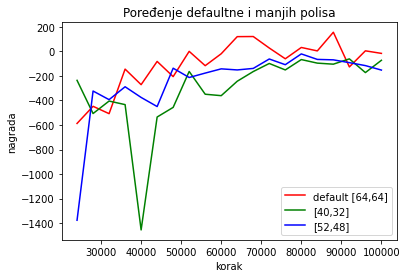

In [ ]:
# crtamo grafik za vizuelno poređenje defaultne i manjih polisa

n=5

x1 = logovi_1['timesteps'][n:]
y1 = np.mean(logovi_1['results'][n:], axis=1)
plt.plot(x1,y1,label="default [64,64]",color="red")

x2 = logovi_2['timesteps'][n:]
y2 = np.mean(logovi_2['results'][n:], axis=1)
plt.plot(x2,y2,label="[40,32]",color="green")

x3 = logovi_3['timesteps'][n:]
y3 = np.mean(logovi_3['results'][n:], axis=1)
plt.plot(x3,y3,label="[52,48]",color="blue")

plt.title("Poređenje defaultne i manjih polisa")
plt.xlabel('korak')
plt.ylabel('nagrada')
plt.legend(loc="lower right")

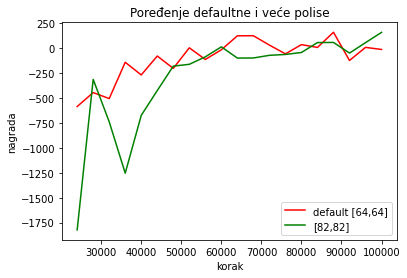

In [ ]:
# crtamo grafik za vizuelno poređenje defaultne i veće polise

n=5

x1 = logovi_1['timesteps'][n:]
y1 = np.mean(logovi_1['results'][n:], axis=1)
plt.plot(x1,y1,label="default [64,64]",color="red")

x4 = logovi_4['timesteps'][n:]
y4 = np.mean(logovi_4['results'][n:], axis=1)
plt.plot(x4,y4,label="[82,82]",color="green")

plt.title("Poređenje defaultne i veće polise")
plt.xlabel('korak')
plt.ylabel('nagrada')
plt.legend(loc="lower right")

Poslednji grafik je malo nezgodan. Naime, na samom kraju zelena polisa izgleda za nijansu bolje. Da bismo bili sigurni, testiraćemo opet ta dva slučaja, ovaj put po 300k koraka.

In [ ]:
# polisa po default-u, 300k koraka
paralelno_okruzenje=make_vec_env("LunarLander-v2",n_envs=4,seed=42)

najbolji_model_eksperiment1_putanja = projekat_folder + "proba_seed=42_300k"
logovi_evaluacije_eksperiment1_putanja = projekat_folder + "log_proba_seed=42_300k"

eval_callback = EvalCallback(okruzenje, best_model_save_path=najbolji_model_eksperiment1_putanja,
                             log_path=logovi_evaluacije_eksperiment1_putanja, eval_freq=1000,
                             deterministic=True, render=False)

model = A2C('MlpPolicy',paralelno_okruzenje,seed=42,verbose=1)
model.learn(300000, callback=eval_callback,log_interval=5000)

In [ ]:
# polisa [82,82], 300k koraka

policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=[dict(pi=[82, 82], vf=[82, 82])])
paralelno_okruzenje=make_vec_env("LunarLander-v2",n_envs=4,seed=42)

najbolji_model_eksperiment1_putanja = projekat_folder + "best_modelA2C[82,82]_seed=42"
logovi_evaluacije_eksperiment1_putanja = projekat_folder + "log_best_modelA2C[82,82]_seed=42"

eval_callback = EvalCallback(okruzenje, best_model_save_path=najbolji_model_eksperiment1_putanja,
                             log_path=logovi_evaluacije_eksperiment1_putanja, eval_freq=1000,
                             deterministic=True, render=False)



model = A2C('MlpPolicy',paralelno_okruzenje,policy_kwargs=policy_kwargs,seed=42,verbose=1)

model.learn(300000, callback=eval_callback,log_interval=5000)

In [ ]:
# ponovo učitavanja

putanja_logova=projekat_folder+"log_proba_seed=42_300k/evaluations.npz"
logovi_1=np.load(putanja_logova)

putanja_logova=projekat_folder+"log_best_modelA2C[82,82]_seed=42/evaluations.npz"
logovi_4=np.load(putanja_logova)

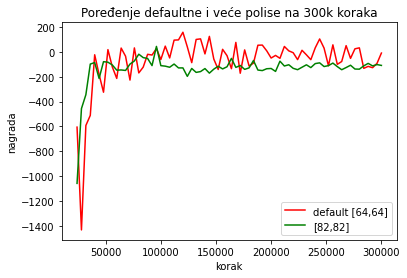

In [ ]:
# ponovo grafik
n=5

x1 = logovi_1['timesteps'][n:]
y1 = np.mean(logovi_1['results'][n:], axis=1)
plt.plot(x1,y1,label="default [64,64]",color="red")

x4 = logovi_4['timesteps'][n:]
y4 = np.mean(logovi_4['results'][n:], axis=1)
plt.plot(x4,y4,label="[82,82]",color="green")

plt.title("Poređenje defaultne i veće polise na 300k koraka")
plt.xlabel('korak')
plt.ylabel('nagrada')
plt.legend(loc="lower right")

Sada je situacija jasna - najbolje je koristi polisu po defaultu

**Gama**

In [ ]:
# najbolji model kada je gama po default-u već imamo iz prethodnog  u "proba_seed=42_300k"
# (odeljak "Polisa" --> "Grafičko prikazivanje rezultata")

# gama=0.95
paralelno_okruzenje=make_vec_env("LunarLander-v2",n_envs=4,seed=42)

najbolji_model_eksperiment1_putanja = projekat_folder + "0.95p"
logovi_evaluacije_eksperiment1_putanja = projekat_folder + "log_0.95p"

eval_callback = EvalCallback(okruzenje, best_model_save_path=najbolji_model_eksperiment1_putanja,
                             log_path=logovi_evaluacije_eksperiment1_putanja, eval_freq=1000,
                             deterministic=True, render=False)



model = A2C('MlpPolicy',paralelno_okruzenje,gamma=0.95,seed=42,verbose=1)

model.learn(300000, callback=eval_callback,log_interval=5000)

Evaluiranjem ova dva modela (ćelije ispod) dobijamo sledeće rezultate: 
1. -2 +- 162 (model sa gamma = 0.99 - default)
2. 90 +- 133 (model sa gamma = 0.95
Uočavamo da je bolje u drugom slučaju. Probajmo sada model gde je gamma = 0.98

In [ ]:
#gama=0.98

paralelno_okruzenje=make_vec_env("LunarLander-v2",n_envs=4,seed=42)

najbolji_model_eksperiment1_putanja = projekat_folder + "0.98p"
logovi_evaluacije_eksperiment1_putanja = projekat_folder + "log_0.98p"

eval_callback = EvalCallback(okruzenje, best_model_save_path=najbolji_model_eksperiment1_putanja,
                             log_path=logovi_evaluacije_eksperiment1_putanja, eval_freq=1000,
                             deterministic=True, render=False)



model = A2C('MlpPolicy',paralelno_okruzenje,gamma=0.98,seed=42,verbose=1)

model.learn(300000, callback=eval_callback,log_interval=5000)

Ovaj model je još bolji: 164 +- 105. Sada već možemo napraviti pretpostavku - što se dalje pomeramo od vrednosti 0.98, rezultati su gori. Proverimo.

In [ ]:
# gama=0.97

paralelno_okruzenje=make_vec_env("LunarLander-v2",n_envs=4,seed=42)

najbolji_model_eksperiment1_putanja = projekat_folder + "0.97"
logovi_evaluacije_eksperiment1_putanja = projekat_folder + "log_0.97"

eval_callback = EvalCallback(okruzenje, best_model_save_path=najbolji_model_eksperiment1_putanja,
                             log_path=logovi_evaluacije_eksperiment1_putanja, eval_freq=1000,
                             deterministic=True, render=False)



model = A2C('MlpPolicy',paralelno_okruzenje,gamma=0.97,seed=42,verbose=1)

model.learn(300000, callback=eval_callback,log_interval=5000)

Ipak naša pretpostavka nije dobra, jer su rezultati za gamma = 0.97 još bolji (212 +- 73). Pretpostavimo sada da je to "granična" vrednost za gama, tj. da što se više udaljavamo od nje, rezultati su gori. Proverimo.

In [ ]:
# gama=0.96

paralelno_okruzenje=make_vec_env("LunarLander-v2",n_envs=4,seed=42)

najbolji_model_eksperiment1_putanja = projekat_folder + "0.96"
logovi_evaluacije_eksperiment1_putanja = projekat_folder + "log_0.96"

eval_callback = EvalCallback(okruzenje, best_model_save_path=najbolji_model_eksperiment1_putanja,
                             log_path=logovi_evaluacije_eksperiment1_putanja, eval_freq=1000,
                             deterministic=True, render=False)



model = A2C('MlpPolicy',paralelno_okruzenje,gamma=0.96,seed=42,verbose=1)

model.learn(300000, callback=eval_callback,log_interval=5000)

Pretpostavka je, izgleda, sasvim u redu. Evalacijom u nekoliko ćelija ispod, dobijamo za ovaj model sledeće: 151 +- 108. Dakle, gori je od modela sa gamma = 0.97.

Rezultati evaluacija su strogo opadajući kada krenemo od najboljeg modela (gamma = 0.97):

212 +- 73 (0.97) > 151 +- 108 (0.96) > 90 +- 133 (0.95)

212 +- 73 (0.97) > 164 +- 105 (0.98) > -17 +- 173 (0.99)

Čisto zbog sigurnosti, a i zanimljivosti, proverimo jošza gamma = 0.995 (veće od default-a)

In [ ]:
# gama=0.995

paralelno_okruzenje=make_vec_env("LunarLander-v2",n_envs=4,seed=42)

najbolji_model_eksperiment1_putanja = projekat_folder + "0.995"
logovi_evaluacije_eksperiment1_putanja = projekat_folder + "log_0.995"

eval_callback = EvalCallback(okruzenje, best_model_save_path=najbolji_model_eksperiment1_putanja,
                             log_path=logovi_evaluacije_eksperiment1_putanja, eval_freq=1000,
                             deterministic=True, render=False)



model = A2C('MlpPolicy',paralelno_okruzenje,gamma=0.995,seed=42,verbose=1)

model.learn(300000, callback=eval_callback,log_interval=5000)

Dobijamo donekle očekivani rezultat (poslednja ćelija u "Evaluacija"): -7 +- 157.

Očekivano je gori od modela sa gamma = 0.97, ali niz vise nije opadajući:

212 +- 73 (0.97) > 164 +- 105 (0.98) > -17 +- 173 (0.99) **<** -7 +- 157 (0.995)

Nacrtajmo i grafik, da se bolje uoče stvari o kojima pričamo:

<ErrorbarContainer object of 3 artists>

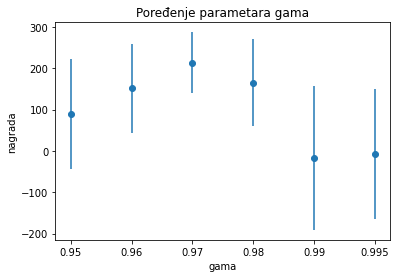

In [ ]:
x=['0.95','0.96','0.97','0.98','0.99','0.995']
y=[90.19,151.11,212.96,164.7,-17.18,-7.2]
e=[133.13,108.38,73.83,105.38,173.86,157.27]

plt.title("Poređenje parametara gama")
plt.xlabel('gama')
plt.ylabel('nagrada')

plt.errorbar(x, y, e, linestyle='None', marker='o')

Evaluacija

In [ ]:
ime_okruzenja = "LunarLander-v2"
okruzenje = gym.make(ime_okruzenja)
spec = gym.spec(ime_okruzenja)
okruzenje.seed(83)

model = A2C.load(projekat_folder + "proba_seed=42_300k/best_model")

mean_reward, std_reward = evaluate_policy(model, okruzenje, n_eval_episodes=100)
print(f"Srednja nagrada: {mean_reward}, st. devijacija nagrade: {std_reward}")

/usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


Srednja nagrada: -17.182549875674727, st. devijacija nagrade: 173.8603592123518


In [ ]:
ime_okruzenja = "LunarLander-v2"
okruzenje = gym.make(ime_okruzenja)
spec = gym.spec(ime_okruzenja)
okruzenje.seed(83)

model = A2C.load(projekat_folder + "0.95p/best_model")

mean_reward, std_reward = evaluate_policy(model, okruzenje, n_eval_episodes=100)
print(f"Srednja nagrada: {mean_reward}, st. devijacija nagrade: {std_reward}")

/usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


Srednja nagrada: 90.18714533078374, st. devijacija nagrade: 133.13132775413814


In [ ]:
ime_okruzenja = "LunarLander-v2"
okruzenje = gym.make(ime_okruzenja)
spec = gym.spec(ime_okruzenja)
okruzenje.seed(83)

model = A2C.load(projekat_folder + "0.98p/best_model")

mean_reward, std_reward = evaluate_policy(model, okruzenje, n_eval_episodes=100)
print(f"Srednja nagrada: {mean_reward}, st. devijacija nagrade: {std_reward}")

/usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


Srednja nagrada: 164.70002083054456, st. devijacija nagrade: 105.37864872520652


In [ ]:
ime_okruzenja = "LunarLander-v2"
okruzenje = gym.make(ime_okruzenja)
spec = gym.spec(ime_okruzenja)
okruzenje.seed(83)

model = A2C.load(projekat_folder + "0.97/best_model")

mean_reward, std_reward = evaluate_policy(model, okruzenje, n_eval_episodes=100)
print(f"Srednja nagrada: {mean_reward}, st. devijacija nagrade: {std_reward}")

/usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


Srednja nagrada: 212.95865772541504, st. devijacija nagrade: 73.82579669032475


In [ ]:
ime_okruzenja = "LunarLander-v2"
okruzenje = gym.make(ime_okruzenja)
spec = gym.spec(ime_okruzenja)
okruzenje.seed(83)

model = A2C.load(projekat_folder + "0.96/best_model")

mean_reward, std_reward = evaluate_policy(model, okruzenje, n_eval_episodes=100)
print(f"Srednja nagrada: {mean_reward}, st. devijacija nagrade: {std_reward}")

/usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


Srednja nagrada: 151.11312158844953, st. devijacija nagrade: 108.37556168066511


In [ ]:
ime_okruzenja = "LunarLander-v2"
okruzenje = gym.make(ime_okruzenja)
spec = gym.spec(ime_okruzenja)
okruzenje.seed(83)

model = A2C.load(projekat_folder + "0.995/best_model")

mean_reward, std_reward = evaluate_policy(model, okruzenje, n_eval_episodes=100)
print(f"Srednja nagrada: {mean_reward}, st. devijacija nagrade: {std_reward}")

/usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


Srednja nagrada: -7.197239056312673, st. devijacija nagrade: 157.26875373165848


Grafičko predstavljanje rezultata

In [ ]:
#učitavamo vrednosti tokom treninga (korake, nagrade i dužine epizoda)



putanja_logova=projekat_folder+"log_0.97/evaluations.npz"
logovi_1=np.load(putanja_logova)

putanja_logova=projekat_folder+"log_0.95p/evaluations.npz"
logovi_3=np.load(putanja_logova)
print(f"Dostupni podfajlovi: \n{logovi_3.files}")

Dostupni podfajlovi: 
['timesteps', 'results', 'ep_lengths']


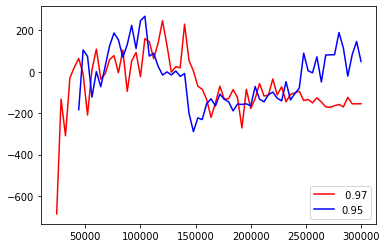

In [ ]:
n=5

x1 = logovi_1['timesteps'][n:]
y1 = np.mean(logovi_1['results'][n:], axis=1)
plt.plot(x1,y1,label=" 0.97",color="red")

x3 = logovi_3['timesteps'][n:]
y3 = np.mean(logovi_3['results'][n:], axis=1)
plt.plot(x2,y2,label="0.95",color="blue")


plt.legend(loc="lower right")

Evo onoga što smo spomenuli ranije (u "Polisa" --> "Evaluacija"). Grafik nedvosmisleno kaže da je model sa gamma = 0.95 bolji od onog sa gamma = 0.97, iako znamo da nije tako.

Da ne ispadne da smo "naboli" baš jedan jedini slučaj kada je crveni bolji od plavog modela, možemo evaluirati i bez seed-a.
Crveni model se i dalje  pokazuje bolje.

**Zaključak**

Najbolji model pomoću A2C-a bi bio sa sledećim parametrima: 300k koraka, defaultna polisa (2 sloja sa po 64 neurona) i gama=0.97.

In [ ]:
# taj model je već napravljen gore i sad samo treba da ga preuzmemo
model = A2C.load(projekat_folder + "0.97/best_model")

In [ ]:
# u ovoj ćeliji možemo da treniramo model od početka sa tim parametrima (nema potreba ako već imamo gotov model)

paralelno_okruzenje=make_vec_env("LunarLander-v2",n_envs=4)

najbolji_model_eksperiment1_putanja = projekat_folder + "najbolji_model"
logovi_evaluacije_eksperiment1_putanja = projekat_folder + "najbolji_model"

eval_callback = EvalCallback(okruzenje, best_model_save_path=najbolji_model_eksperiment1_putanja,
                             log_path=logovi_evaluacije_eksperiment1_putanja, eval_freq=1000,
                             deterministic=True, render=False)


model = A2C('MlpPolicy',paralelno_okruzenje,gamma=0.97,seed=42,verbose=1)
model.learn(300000, callback=eval_callback,log_interval=5000)

In [ ]:
# evaluacija - srednja nagrada i std

okruzenje.reset()

mean_reward, std_reward = evaluate_policy(model, okruzenje, n_eval_episodes=100)
print(f"Srednja nagrada: {mean_reward}, st. devijacija nagrade: {std_reward}")

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


Srednja nagrada: 192.99977665206075, st. devijacija nagrade: 90.9574107220116


In [ ]:
# evaluacija - procenat pobede
okruzenje.reset()

episode_reward, episode_len = evaluate_policy(model, okruzenje, n_eval_episodes=100,return_episode_rewards=True)

episode_reward_np=np.array(episode_reward)
len(episode_reward_np[episode_reward_np>=200])

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


74

In [ ]:
# da vidimo i kako to izgleda na videu :-)

video = VideoRecorder(okruzenje, video_putanja)

gotovo = False
stanje = okruzenje.reset()  # resetujemo okruženje, započinjemo novu epizodu i dobijamo referencu na početno stanje
ukupna_nagrada = 0
while not gotovo:
    akcija, _ = model.predict(stanje)
    stanje, nagrada, gotovo, info = okruzenje.step(akcija)
    ukupna_nagrada += nagrada
    video.capture_frame()
video.close()
print(f"Ukupna nagrada {ukupna_nagrada} ")

/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:116: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  '`env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` '


Ukupna nagrada 248.35343325098563 


In [ ]:
HTML(render_mp4(video_putanja))

# **PPO - Proximal Policy Optimization**
---



In [ ]:
from stable_baselines3 import PPO

**PPO** u suštini predstavlja poboljšani A2C algoritam. Njegove promene tokom treniranja, za razliku od A2C-a su stabilnije i zato hajde da vidimo kakav će to uticaj imati na konačne rezultate istreniranog agenta. 

*Da li će on zaista biti bolji od A2C-a?*

In [ ]:
seed = 42
paralelno_okruzenje = make_vec_env(ime_okruzenja, n_envs=20)
paralelno_okruzenje.seed(seed)

eval_okruzenje = gym.make(ime_okruzenja)
eval_okruzenje.seed(seed)

/usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


[42]

**Prvo ćemo testirati rezultate sa parametrima koji su se najbolje pokazali u opštem slučaju...**

In [ ]:
najbolji_model_putanja = projekat_folder + "best_modelPPO[40,32]_100k_n_envs=10"
logovi_evaluacije_putanja = projekat_folder + "logs_best_modelPPO[40,32]_100k_n_envs=10"

eval_callback = EvalCallback(eval_okruzenje, best_model_save_path=najbolji_model_putanja,
                             log_path=logovi_evaluacije_putanja, eval_freq=1000,
                             deterministic=True, render=False)

policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[dict(pi=[40,32], vf=[40,32])])
PPO_model = PPO("MlpPolicy", okruzenje, gamma = 0.99, policy_kwargs=policy_kwargs, verbose = 1)
PPO_model.learn(total_timesteps=100000, log_interval=1000, callback=eval_callback)
PPO_model = PPO.load(najbolji_model_putanja + "/best_model")

Sada kada imamo istreniran model, možemo da ga **evaluiramo** i tako proverimo kako se nosi sa problemom u zadatom okruženju.

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

eval_okruzenje.reset(seed=seed)
mean_reward, std_reward = evaluate_policy(PPO_model, eval_okruzenje, n_eval_episodes=100)
print(f"Srednja nagrada: {mean_reward}, st. devijacija nagrade: {std_reward}")

Rezultati ne prelaze prag nagrade i nisu zadovoljavajući, ali to možemo lako da promenimo menjanjem parametara modela.

Moguće je da smo podcenili složenost problema, zato hajde da proširimo neuralnu mrežu od polise i vrednosne funkcije, prvo ćemo početi sa veličinom od [64, 64], to je početna za metod PPO(...)

In [ ]:
najbolji_model_putanja = projekat_folder + "best_modelPPO[64,64]_100k_n_envs=10"
logovi_evaluacije_putanja = projekat_folder + "logs_best_modelPPO[64,64]_100k_n_envs=10"

eval_callback = EvalCallback(eval_okruzenje, best_model_save_path=najbolji_model_putanja,
                             log_path=logovi_evaluacije_putanja, eval_freq=1000,
                             deterministic=True, render=False)

policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[dict(pi=[64,64], vf=[64,64])])
PPO_model = PPO("MlpPolicy", okruzenje, gamma = 0.99, policy_kwargs=policy_kwargs, verbose = 1)
PPO_model.learn(total_timesteps=100000, log_interval=1000, callback=eval_callback)
PPO_model = PPO.load(najbolji_model_putanja + "/best_model")

In [ ]:
eval_okruzenje.reset(seed=seed)
mean_reward, std_reward = evaluate_policy(PPO_model, eval_okruzenje, n_eval_episodes=100)
print(f"Srednja nagrada: {mean_reward}, st. devijacija nagrade: {std_reward}")

Vidi se poboljšanje, ali idalje može bolje.

In [ ]:
najbolji_model_putanja = projekat_folder + "best_modelPPO[128,128]_100k_n_envs=10"
logovi_evaluacije_putanja = projekat_folder + "logs_best_modelPPO[128,128]_100k_n_envs=10"

eval_callback = EvalCallback(eval_okruzenje, best_model_save_path=najbolji_model_putanja,
                             log_path=logovi_evaluacije_putanja, eval_freq=1000,
                             deterministic=True, render=False)

policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[dict(pi=[128,128], vf=[128,128])])
PPO_model = PPO("MlpPolicy", okruzenje, gamma = 0.99, policy_kwargs=policy_kwargs, verbose = 1)
PPO_model.learn(total_timesteps=100000, log_interval=1000, callback=eval_callback)
PPO_model = PPO.load(najbolji_model_putanja + "/best_model")

Rezultati idalje ne prelaze prag nagrade i nisu zadovoljavajući, ali zašto je to tako? Odgovor se krije u logovima!

In [ ]:
putanja_logova = logovi_evaluacije_putanja + "/evaluations.npz"
logovi_eksperimenata = np.load(putanja_logova)

import matplotlib.pyplot as plt

x = logovi_eksperimenata['timesteps'][:]
y = np.mean(logovi_eksperimenata['results'][:], axis=1)
plt.xlabel="koraci"
plt.ylabel="rezultati"
plt.plot(x,y)

print(x)
print(y)

Sada vidimo, iz oblika krive, da loši rezultati možda potiču od malog broja koraka za koje se agent trenira, ipak bi trebalo bolje da se upozna sa okruženjem u kom se nalazi. 

U sledećoj sesiji treniranja ćemo probati znatno veću vrednost koraka, da vidimo kakav uticaj to ima na rešenje...

In [ ]:
najbolji_model_putanja = projekat_folder + "best_modelPPO[128,128]_1000k_n_envs=10"
logovi_evaluacije_putanja = projekat_folder + "logs_best_modelPPO[128,128]_1000k_n_envs=10"

eval_callback = EvalCallback(eval_okruzenje, best_model_save_path=najbolji_model_putanja,
                             log_path=logovi_evaluacije_putanja, eval_freq=1000,
                             deterministic=True, render=False)

policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[dict(pi=[40,32], vf=[40,32])])
PPO_model = PPO("MlpPolicy", okruzenje, gamma = 0.99, policy_kwargs=policy_kwargs, verbose = 1)
PPO_model.learn(total_timesteps=1000000, log_interval=1000, callback=eval_callback)
PPO_model = PPO.load(najbolji_model_putanja + "/best_model")

In [ ]:
eval_okruzenje.reset(seed=seed)
mean_reward, std_reward = evaluate_policy(PPO_model, eval_okruzenje, n_eval_episodes=100)
print(f"Srednja nagrada: {mean_reward}, st. devijacija nagrade: {std_reward}")

In [ ]:
putanja_logova = logovi_evaluacije_putanja + "/evaluations.npz"
logovi_eksperimenata = np.load(putanja_logova)

x = logovi_eksperimenata['timesteps'][:]
y = np.mean(logovi_eksperimenata['results'][:], axis=1)
plt.xlabel="koraci"
plt.ylabel="rezultati"
plt.plot(x,y)

print(x)
print(y)

E sada se vidi najbolji rezultat! Tokom lokalnog rada na projektu rezultati evaluacije ovog modela su bili:

Srednja nagrada: 275.7122282708247, st. devijacija nagrade: 17.08913631593638

Što znači da je agent pobedio **svaku** epizodu i ovim vidimo da, na prvi pogled mala razlika između А2C i PPO algoritma, ima velik uticaj na konačno rešenje.

**Zaključak:** PPO algoritam je u ovom slučaju bolji od A2C algoritma jer je došao do najoptimalnijeg rešenja.

Rešenje ovog problema se može dalje poboljšati menjanjem parametra gamma ili testiranjem šta će se desiti sa dodatnim povećanjem koraka. Naravno tada treba da uzmemo u obzir da li je vredno čekati da se završi velik broj koraka treninga za određeno poboljšanje.

Na kraju, hajde da prikažemo proces treniranja svih modela preko grafika...

In [ ]:
putanja_logova_modela_1 = projekat_folder + "logs_best_modelPPO[40,32]_100k_n_envs=10"
putanja_logova_modela_2 = projekat_folder + "logs_best_modelPPO[64,64]_100k_n_envs=10"
putanja_logova_modela_3 = projekat_folder + "logs_best_modelPPO[128,128]_100k_n_envs=10"
putanja_logova_modela_4 = projekat_folder + "logs_best_modelPPO[128,128]_1000k_n_envs=10"

logovi_modela_1 = np.load(putanja_logova_modela_1)
logovi_modela_2 = np.load(putanja_logova_modela_2)
logovi_modela_3 = np.load(putanja_logova_modela_3)
logovi_modela_4 = np.load(putanja_logova_modela_4)

x1 = logovi_modela_1['timesteps'][:]
y1 = np.mean(logovi_modela_1['results'][:], axis=1)
plt.plot(x1,y1,label=" prvi model",color="red")

x2 = logovi_modela_2['timesteps'][:]
y2 = np.mean(logovi_modela_2['results'][:], axis=1)
plt.plot(x2,y2,label=" drugi model",color="yellow")

x3 = logovi_modela_3['timesteps'][:]
y3 = np.mean(logovi_modela_3['results'][:], axis=1)
plt.plot(x3,y3,label=" treći model",color="green")

plt.legend(loc="lower right")

In [ ]:
x4 = logovi_modela_4['timesteps'][:]
y4 = np.mean(logovi_modela_4['results'][:], axis=1)
plt.plot(x4,y4,label=" četvrti model",color="blue")

Ovde je prikazan samo najbolji model, treniran na najvećem broju koraka od svih ostalih modela.

# **Zaključak**

Ovde ćemo uporediti najbolje model od svakog algoritma, grafički.

<ErrorbarContainer object of 3 artists>

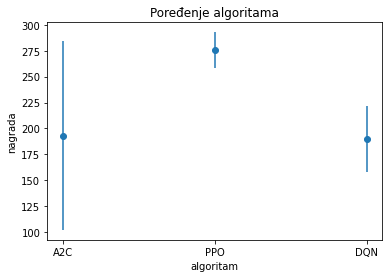

In [ ]:
x=['A2C','PPO','DQN']
y=[193,275.71,189.95]
e=[90.96,17.09,31.74]

plt.title("Poređenje algoritama")
plt.xlabel('algoritam')
plt.ylabel('nagrada')

plt.errorbar(x, y, e, linestyle='None', marker='o')

## **LunarLanderContinuous-v2**

In [ ]:
import gym

ime_okruzenja = "LunarLanderContinuous-v2" # biramo okruženje za igranje.
okruzenje = gym.make(ime_okruzenja) # učitavamo odabrano okruženje, tj. problem.
spec = gym.spec(ime_okruzenja) # učitavamo specifikaciju odabranog okruženja
okruzenje.seed(42) # fiksiranje nasumicnosti da bi se okruzenje isto ponasalo kad ponovimo program 

print(f"Akcije okruženja: { okruzenje.action_space }")
print(f"Dimenzije stanja: { okruzenje.observation_space }")
print(f"Maksimalan broj koraka: { spec.max_episode_steps }")
print(f"Opseg vrednosti nagrade: { okruzenje.reward_range }")
print(f"Prag nagrade: { spec.reward_threshold }") 

Akcije okruženja: Box(-1.0, 1.0, (2,), float32)
Dimenzije stanja: Box(-inf, inf, (8,), float32)
Maksimalan broj koraka: 1000
Opseg vrednosti nagrade: (-inf, inf)
Prag nagrade: 200


/usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


# **DDQN**

Ovaj algoritam radi isključino sa kontinualnim podacima. Optimizuje i polisu i  Q(s,a) vrednost. Narano, uči i vrednosnu funkciju stanja V(s). Stoga, dosta je složen.

In [ ]:
from stable_baselines3 import DDPG

Prvo ćemo pokrenuti trening sa defaultnim vrednostima, za 300k koraka. Nećemo baš preterivati sa koracima, jer je DDQN dosta sporiji od drugih algoritama (složenost!), npr. A2C-a i PPO-a. Oni su, doduše, mogli da se treniraju i u vektorskom okruženju, što je dosta ubrzavalo stvari. Ovde to nije slučaj. Treba više od 3 sata za 300k koraka!

Istovremeno ćemo probati da promenimo gama na npr. 0.95 (davalo je rezultate kod A2C-a) i igraćemo se sa action_noise_om.





Sa njim nismo imali prilike da se susretnemo u prethodnim algoritmima. Naime, on pospešuje istraživanje (entropija) i po default-u ga nema u DDQN. 

In [ ]:
# default
najbolji_model_eksperiment1_putanja = projekat_folder + "DDPG_300k"
logovi_evaluacije_eksperiment1_putanja = projekat_folder + "log_DDPG_300k"

eval_callback = EvalCallback(okruzenje, best_model_save_path=najbolji_model_eksperiment1_putanja,
                             log_path=logovi_evaluacije_eksperiment1_putanja, eval_freq=1000,
                             deterministic=True, render=False)


model = DDPG('MlpPolicy',okruzenje, verbose=1)
model.learn(300000,callback=eval_callback,log_interval=5000)

In [ ]:
# action_noise
from stable_baselines3.common.noise import NormalActionNoise
najbolji_model_eksperiment1_putanja = projekat_folder + "DDPG_300k_noise"
logovi_evaluacije_eksperiment1_putanja = projekat_folder + "log_DDPG_300k_noise"

eval_callback = EvalCallback(okruzenje, best_model_save_path=najbolji_model_eksperiment1_putanja,
                             log_path=logovi_evaluacije_eksperiment1_putanja, eval_freq=1000,
                             deterministic=True, render=False)

n_actions=okruzenje.action_space.shape[-1]
action_noise=NormalActionNoise(mean=np.zeros(n_actions),sigma=0.1*np.ones(n_actions))

# nećemo preterivati sa noise-om, imajući u vidu exploataciju
# srednja vrednost je nula, a std 0.1 (u nizu dužine broja akcija)

model = DDPG('MlpPolicy', okruzenje,action_noise=action_noise,verbose=1)
model.learn(300000,callback=eval_callback,log_interval=5000)

In [ ]:
najbolji_model_eksperiment1_putanja = projekat_folder + "DDPG_300k_gama=0.95"
logovi_evaluacije_eksperiment1_putanja = projekat_folder + "log_DDPG_300k_gama=0.95"

eval_callback = EvalCallback(okruzenje, best_model_save_path=najbolji_model_eksperiment1_putanja,
                             log_path=logovi_evaluacije_eksperiment1_putanja, eval_freq=1000,
                             deterministic=True, render=False)


model = DDPG('MlpPolicy',okruzenje,gamma=0.95, verbose=1)
model.learn(300000,callback=eval_callback,log_interval=5000)

**Izgled treninga**

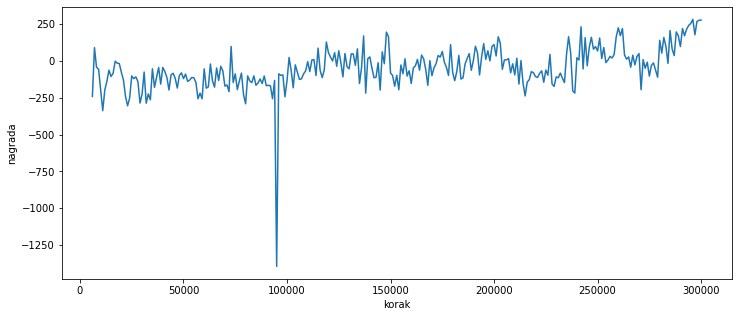

In [ ]:
# default
putanja_logova=projekat_folder+"log_DDPG_300k/evaluations.npz"
logovi=np.load(putanja_logova)

x = logovi['timesteps'][5:] 
y = np.mean(logovi['results'][5:], axis=1)
# ne crtamo prvih 5 tačaka, jer su vrednosti na y - osi ogromne
# i ne vide se lepo nagrade na većem rednom broju koraka

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(5)

plt.xlabel('korak')
plt.ylabel('nagrada')

plt.plot(x,y)

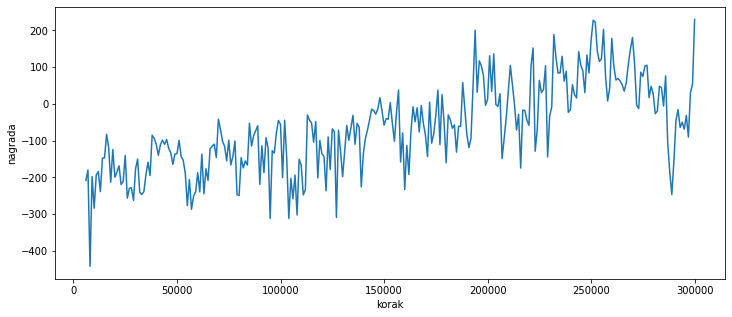

In [ ]:
# action_noise
putanja_logova=projekat_folder+"log_DDPG_300k_noise/evaluations.npz"
logovi=np.load(putanja_logova)
x = logovi['timesteps'][5:] 
y = np.mean(logovi['results'][5:], axis=1)


f = plt.figure()
f.set_figwidth(12)
f.set_figheight(5)

plt.xlabel('korak')
plt.ylabel('nagrada')

plt.plot(x,y)

Uočimo koliko su ovde naglije promene nego u prvom grafiku - exploration.

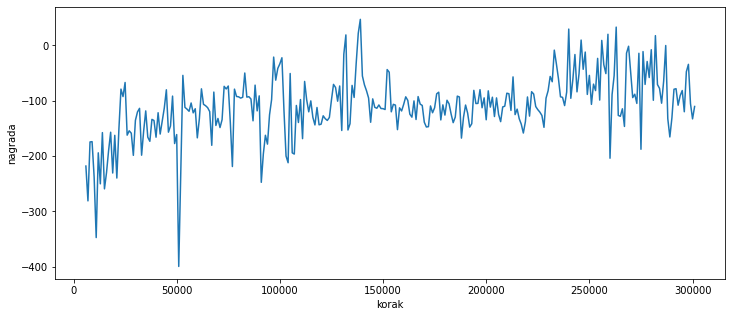

In [ ]:
# gama=0.95
putanja_logova=projekat_folder+"log_DDPG_300k_gama=0.95/evaluations.npz"
logovi=np.load(putanja_logova)
x = logovi['timesteps'][5:] 
y = np.mean(logovi['results'][5:], axis=1)


f = plt.figure()
f.set_figwidth(12)
f.set_figheight(5)

plt.xlabel('korak')
plt.ylabel('nagrada')

plt.plot(x,y)

Iz ovih grafika (naročito prvog i drugog) vidimo da ima dosta poboljšanja u poslednjem trenutku. Jedna ideja za pravljenje boljeg modela bi onda bila nastaviti trening za još npr. 300k koraka. 

**Evaluacija**

In [ ]:
# default
ime_okruzenja = "LunarLanderContinuous-v2"
okruzenje = gym.make(ime_okruzenja)
spec = gym.spec(ime_okruzenja)

model = DDPG.load(projekat_folder + "DDPG_300k/best_model")

mean_reward, std_reward = evaluate_policy(model, okruzenje, n_eval_episodes=100,deterministic=True)
print(f"Srednja nagrada: {mean_reward}, st. devijacija nagrade: {std_reward}")

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


Srednja nagrada: 178.57338968915275, st. devijacija nagrade: 168.74870890876682


In [ ]:
#action_noise
ime_okruzenja = "LunarLanderContinuous-v2"
okruzenje = gym.make(ime_okruzenja)
spec = gym.spec(ime_okruzenja)

model = DDPG.load(projekat_folder + "DDPG_300k_noise/best_model")

mean_reward, std_reward = evaluate_policy(model, okruzenje, n_eval_episodes=100,deterministic=True)
print(f"Srednja nagrada: {mean_reward}, st. devijacija nagrade: {std_reward}")

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


Srednja nagrada: 119.31656125829333, st. devijacija nagrade: 178.3926584303297


In [ ]:
#gama=0.95
from stable_baselines3.common.evaluation import evaluate_policy
ime_okruzenja = "LunarLanderContinuous-v2"
okruzenje = gym.make(ime_okruzenja)
spec = gym.spec(ime_okruzenja)

model = DDPG.load(projekat_folder + "DDPG_300k_gama=0.95/best_model")

mean_reward, std_reward = evaluate_policy(model, okruzenje, n_eval_episodes=100,deterministic=True)
print(f"Srednja nagrada: {mean_reward}, st. devijacija nagrade: {std_reward}")

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


Srednja nagrada: -46.76191605947878, st. devijacija nagrade: 100.65066760674029


**Zaključak**

Algoritam po defaultnim vrednostima daje najbolje rezultate i verovatno će davati još bolje ako se trening produži (za npr. 300k koraka).
Isto važi i za "action_noise model". Iako on daje malo gore rezultate, rast njegovog grafika u skroz poslednjim koracima je najveći.

# **PPO - Kontinualni problem**

In [ ]:
from stable_baselines3 import PPO

**PPO** algotitam ima sposobnost da se koristi i na problemima sa diskretnim vrednostima i na problemima sa kontinualnim vrednostima. Naravno ta okruženja se značajno razliku, tako da se postavlja pitanje "*Kako će ta promena uticati na performanse algoritma PPO?*" 

In [ ]:
ime_okruzenja = "LunarLanderContinuous-v2"
eval_okruzenje = gym.make(ime_okruzenja)
broj_okruzenja = 100
okruzenje = make_vec_env(ime_okruzenja, n_envs=broj_okruzenja)
okruzenje.seed(seed)

In [ ]:
najbolji_model_putanja = projekat_folder + "best_model_[128,128]_1000k"
logovi_evaluacije_putanja = projekat_folder + "logs_best_model_[128,128]_1000k"

eval_callback = EvalCallback(eval_okruzenje, best_model_save_path=najbolji_model_putanja,
                             log_path=logovi_evaluacije_putanja, n_eval_episodes=100, eval_freq=1000,
                             deterministic=True, render=False)

policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[dict(pi=[128,128], vf=[128,128])])
PPO_model = PPO("MlpPolicy", okruzenje, gamma = 0.99, policy_kwargs=policy_kwargs, verbose = 1)
PPO_model.learn(total_timesteps=1000000, log_interval=1000, callback=eval_callback)
PPO_model = PPO.load(najbolji_model_putanja + "/best_model")

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

eval_okruzenje.reset(seed=seed)
mean_reward, std_reward = evaluate_policy(PPO_model, eval_okruzenje, n_eval_episodes=100)
print(f"Srednja nagrada: {mean_reward}, st. devijacija nagrade: {std_reward}")

Za date parametre dobijeni su sledeći rezultati:

Srednja nagrada: -47.05433856279508, st. devijacija nagrade: 115.17427713034863

Model se nije najbolje pokazao sa ovakvom konfiguracijom, zato ćemo tokom sledećeg treniranja koristiti drugačiju neuralnu mrežu.

Možda je ova previše složena, zato hajde da posmatramo prvobitne neuralne mreže za polisu i vrednosnu funkciju, koje automatski postavlja metod PPO(...), veličine su [64, 64]

In [ ]:
najbolji_model_putanja = projekat_folder + "best_model_[64,64]_1000k"
logovi_evaluacije_putanja = projekat_folder + "logs_best_model_[64,64]_1000k"

eval_callback = EvalCallback(eval_okruzenje, best_model_save_path=najbolji_model_putanja,
                             log_path=logovi_evaluacije_putanja, n_eval_episodes=100, eval_freq=1000,
                             deterministic=True, render=False)

policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[dict(pi=[64,64], vf=[64,64])])
PPO_model = PPO("MlpPolicy", okruzenje, gamma = 0.99, policy_kwargs=policy_kwargs, verbose = 1)
PPO_model.learn(total_timesteps=1000000, log_interval=1000, callback=eval_callback)
PPO_model = PPO.load(najbolji_model_putanja + "/best_model")

In [ ]:
eval_okruzenje.reset(seed=seed)
mean_reward, std_reward = evaluate_policy(PPO_model, eval_okruzenje, n_eval_episodes=100)
print(f"Srednja nagrada: {mean_reward}, st. devijacija nagrade: {std_reward}")

Ovaj put je model imao sledeće rezultate:

Srednja nagrada: -83.21557353773886, st. devijacija nagrade: 99.29833248278982



Zaključak je da problem nije toliko jednostavan da ga ova neuralna mreža može rešiti optimalno. Zato ćemo sada značajno povećati veličinu mreža -> na [200, 200]

In [ ]:
najbolji_model_putanja = projekat_folder + "best_model_[200,200]_1000k"
logovi_evaluacije_putanja = projekat_folder + "logs_best_model_[200,200]_1000k"

eval_callback = EvalCallback(eval_okruzenje, best_model_save_path=najbolji_model_putanja,
                             log_path=logovi_evaluacije_putanja, n_eval_episodes=100, eval_freq=1000,
                             deterministic=True, render=False)

policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[dict(pi=[200,200], vf=[200,200])])
PPO_model = PPO("MlpPolicy", okruzenje, gamma = 0.99, policy_kwargs=policy_kwargs, verbose = 1)
PPO_model.learn(total_timesteps=1000000, log_interval=1000, callback=eval_callback)
PPO_model = PPO.load(najbolji_model_putanja + "/best_model")

In [ ]:
eval_okruzenje.reset(seed=seed)
mean_reward, std_reward = evaluate_policy(PPO_model, eval_okruzenje, n_eval_episodes=100)
print(f"Srednja nagrada: {mean_reward}, st. devijacija nagrade: {std_reward}")

Iako bi bilo očekivano da rezultati budu bolji, da se primetiti da to nije slučaj i sada nam ostaje da odaberemo sledeću promenu koju ćemo načiniti. 

Srednja nagrada: -85.32770930034873, st. devijacija nagrade: 77.65885717087552

Ako pođemo od pretpostavke da je više uvek bolje ostaje nam samo da menjamo gamma, počnimo od vrednosti 0.85

In [ ]:
najbolji_model_putanja = projekat_folder + "best_model_[200,200]_gamma=0.85_1000k"
logovi_evaluacije_putanja = projekat_folder + "logs_best_model_[200,200]_gamma=0.85_1000k"

eval_callback = EvalCallback(eval_okruzenje, best_model_save_path=najbolji_model_putanja,
                             log_path=logovi_evaluacije_putanja, n_eval_episodes=100, eval_freq=1000,
                             deterministic=True, render=False)

policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[dict(pi=[200,200], vf=[200,200])])
PPO_model = PPO("MlpPolicy", okruzenje, gamma = 0.85, policy_kwargs=policy_kwargs, verbose = 1)
PPO_model.learn(total_timesteps=1000000, log_interval=1000, callback=eval_callback)
PPO_model = PPO.load(najbolji_model_putanja + "/best_model")

In [ ]:
eval_okruzenje.reset(seed=seed)
mean_reward, std_reward = evaluate_policy(PPO_model, eval_okruzenje, n_eval_episodes=100)
print(f"Srednja nagrada: {mean_reward}, st. devijacija nagrade: {std_reward}")

Rezultati su nasuprot očekivanom još gori:

Srednja nagrada: -117.57555621724569, st. devijacija nagrade: 108.5625385511828

To nam sugeriše da je zapravo problem u neuralnoj mreži, ona je sada postala previše složena i moramo je korigovati na neku vrednosti između 128 i 200. Hajde da kremo od vrednosti koje su bliže 128 jer smo tada dobili dolje rezultate i neka veličina bude 140!

In [ ]:
najbolji_model_putanja = projekat_folder + "best_model_[140,140]_1000k"
logovi_evaluacije_putanja = projekat_folder + "logs_best_model_[140,140]_1000k"

eval_callback = EvalCallback(eval_okruzenje, best_model_save_path=najbolji_model_putanja,
                             log_path=logovi_evaluacije_putanja, n_eval_episodes=100, eval_freq=1000,
                             deterministic=True, render=False)

policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[dict(pi=[140,140], vf=[140,140])])
PPO_model = PPO("MlpPolicy", okruzenje, gamma = 0.99, policy_kwargs=policy_kwargs, verbose = 1)
PPO_model.learn(total_timesteps=1000000, log_interval=1000, callback=eval_callback)
PPO_model = PPO.load(najbolji_model_putanja + "/best_model")

In [ ]:
eval_okruzenje.reset(seed=seed)
mean_reward, std_reward = evaluate_policy(PPO_model, eval_okruzenje, n_eval_episodes=100)
print(f"Srednja nagrada: {mean_reward}, st. devijacija nagrade: {std_reward}")

Rezultati nisu bili utešni...

Srednja nagrada: -73.08620833078257, st. devijacija nagrade: 106.09698621991414

A kada smo promenili gamma na 0.90 ruzultati su se neznatno promenili, i to još na gore!

Srednja nagrada: -93.97449970734544, st. devijacija nagrade: 130.38959741403835

Međutim, problem se krije kao i u običnom problemu u krivi grafika učenja.

In [ ]:
putanja_logova = logovi_evaluacije_putanja + "/evaluations.npz"
logovi_eksperimenata = np.load(putanja_logova)

import matplotlib.pyplot as plt

x = logovi_eksperimenata['timesteps'][:]
y = np.mean(logovi_eksperimenata['results'][:], axis=1)
plt.xlabel="koraci"
plt.ylabel="rezultati"
plt.plot(x,y)

print(x)
print(y)

Iako na prvi pogled izgleda kao da grafik neće preći liniju iznad njega, on liči kao da će nastaviti da raste i upravo to nam ukazuje da je potrebno više koraka kao bi se model istrenirao kvalitetno. Zato hajde da povećamo broj koraka na 1,5 miliona.

In [ ]:
najbolji_model_putanja = projekat_folder + "best_model_[140,140]_1500k"
logovi_evaluacije_putanja = projekat_folder + "logs_best_model_[140,140]_1500k"

eval_callback = EvalCallback(eval_okruzenje, best_model_save_path=najbolji_model_putanja,
                             log_path=logovi_evaluacije_putanja, n_eval_episodes=100, eval_freq=1000,
                             deterministic=True, render=False)

policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[dict(pi=[140,140], vf=[140,140])])
PPO_model = PPO("MlpPolicy", okruzenje, gamma = 0.99, policy_kwargs=policy_kwargs, verbose = 1)
PPO_model.learn(total_timesteps=1500000, log_interval=1000, callback=eval_callback)
PPO_model = PPO.load(najbolji_model_putanja + "/best_model")

In [ ]:
eval_okruzenje.reset(seed=seed)
mean_reward, std_reward = evaluate_policy(PPO_model, eval_okruzenje, n_eval_episodes=100)
print(f"Srednja nagrada: {mean_reward}, st. devijacija nagrade: {std_reward}")

In [ ]:
putanja_logova = logovi_evaluacije_putanja + "/evaluations.npz"
logovi_eksperimenata = np.load(putanja_logova)

x = logovi_eksperimenata['timesteps'][:]
y = np.mean(logovi_eksperimenata['results'][:], axis=1)
plt.xlabel="koraci"
plt.ylabel="rezultati"
plt.plot(x,y)

print(x)
print(y)

Nakon ove promene nastupili su bolji rezultati:

Srednja nagrada: 168.2776823527179, st. devijacija nagrade: 55.198697533521376

Ali grafik idalje izgleda kao da modelu ne bi škodilo još koraka, probajmo 2 miliona.

In [ ]:
najbolji_model_putanja = projekat_folder + "best_model_[140,140]_2000k"
logovi_evaluacije_putanja = projekat_folder + "logs_best_model_[140,140]_2000k"

eval_callback = EvalCallback(eval_okruzenje, best_model_save_path=najbolji_model_putanja,
                             log_path=logovi_evaluacije_putanja, n_eval_episodes=100, eval_freq=1000,
                             deterministic=True, render=False)

policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[dict(pi=[140,140], vf=[140,140])])
PPO_model = PPO("MlpPolicy", okruzenje, gamma = 0.99, policy_kwargs=policy_kwargs, verbose = 1)
PPO_model.learn(total_timesteps=2000000, log_interval=1000, callback=eval_callback)
PPO_model = PPO.load(najbolji_model_putanja + "/best_model")

In [ ]:
eval_okruzenje.reset(seed=seed)
mean_reward, std_reward = evaluate_policy(PPO_model, eval_okruzenje, n_eval_episodes=100)
print(f"Srednja nagrada: {mean_reward}, st. devijacija nagrade: {std_reward}")

In [ ]:
putanja_logova = logovi_evaluacije_putanja + "/evaluations.npz"
logovi_eksperimenata = np.load(putanja_logova)

x = logovi_eksperimenata['timesteps'][:]
y = np.mean(logovi_eksperimenata['results'][:], axis=1)
plt.xlabel="koraci"
plt.ylabel="rezultati"
plt.plot(x,y)

print(x)
print(y)

Nagrada je porasla na:

Srednja nagrada: 226.5595655714492, st. devijacija nagrade: 61.51975696960877

Tako da naš model često i pređe prag nagrade, što znači da smo sa određenim uspehom rešili i onaj problem.

**Zaključak:** Ovde je bitno napomenuti par stvari. Prvo, iako je mreža veličina [128, 128] bila bolja za ovaj problem nego [140, 140], upravo zato što je greška bila povezana sa brojem koraka poboljšanje se videlo i na toj mreži.

Naravno i ovaj problem se može dalje proširiti biranjem mreže veličine [128, 128] i zatim pronalaženjem najoptimalnije vrednosti za gamma.

I konačno, samo okruženje se pokazalo izuzetno zahtevno za sam algoritam, jer je bilo potrebno mnogo više koraka da se agent "navikne" na ovo složeno okruženje čudnih pravila.